In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# データセットができていない場合

まずはmake_train_val_data.ipynbを実行して全データをシャッフルして地震波形(1000,5,1000,70)と速度マップ(10000,1,70,70)のnpyを10個作る
次にmake_small_batches.ipynbを実行して1つのサンプルデータセットtrain(800)とval(200)に分割されたデータセットを作成（npy）

# Unet

In [2]:
# ----------------------------
# 1) モデル定義：ResUNet70x70
# ----------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)

class ResUNet70x70(nn.Module):
    def __init__(self):
        super().__init__()
        # エンコーダ
        self.inc   = DoubleConv(5,  32)
        self.down1 = nn.Sequential(nn.MaxPool2d((2,2)), DoubleConv(32, 64))   # 1000→500,70→35
        self.down2 = nn.Sequential(nn.MaxPool2d((2,2)), DoubleConv(64,128))   # 500→250,35→17
        self.down3 = nn.Sequential(nn.MaxPool2d((2,1)), DoubleConv(128,256))  # 250→125,17→17
        # ボトルネック
        self.bot   = DoubleConv(256,256)
        # デコーダ
        self.up3   = nn.ConvTranspose2d(256,128,kernel_size=(2,1),stride=(2,1))  # 125→250,17→17
        self.dec3  = DoubleConv(256,128)
        self.up2   = nn.ConvTranspose2d(128,64, kernel_size=(2,2),stride=(2,2))  # 250→500,17→34
        self.dec2  = DoubleConv(128,64)
        self.up1   = nn.ConvTranspose2d(64,32,  kernel_size=(2,2),stride=(2,2))  # 500→1000,34→68
        self.dec1  = DoubleConv(64,32)
        # 最終整形
        self.outc  = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        # エンコーダ
        x1 = self.inc(x)        # [B,32,1000,70]
        x2 = self.down1(x1)     # [B,64,500,35]
        x3 = self.down2(x2)     # [B,128,250,17]
        x4 = self.down3(x3)     # [B,256,125,17]
        # ボトルネック
        xb = self.bot(x4)       # [B,256,125,17]
        # デコーダ (スキップ結合)
        x = self.up3(xb)                                   # [B,128,250,17]
        x = torch.cat([x, x3], dim=1)                      # [B,256,250,17]
        x = self.dec3(x)                                   # [B,128,250,17]
        x = self.up2(x)                                    # [B,64,500,34]
        x = torch.cat([x, x2[:,:,:,:34]], dim=1)           # スライスで合わせる
        x = self.dec2(x)                                   # [B,64,500,34]
        x = self.up1(x)                                    # [B,32,1000,68]
        x = torch.cat([x, x1[:,:,:,:68]], dim=1)           # [B,64,1000,68]
        x = self.dec1(x)                                   # [B,32,1000,68]
        # 出力を (1000,70) に合わせる
        x = F.pad(x, (0, 2, 0, 0))                         # 68→70 列パディング
        output = self.outc(x)                              # [B,1,1000,70]
        # 時間方向を70に凝縮（平均プーリングで）
        output = F.adaptive_avg_pool2d(output, (70,70))    # [B,1,70,70]
        return output

In [3]:
# ----------------------------
# 2) Dataset 準備
# ----------------------------
class WaveformDataset(Dataset):
    def __init__(self, waves_path, vels_path):
        self.waves = np.load(waves_path)
        self.vels  = np.load(vels_path)
    def __len__(self):
        return len(self.waves)
    def __getitem__(self, idx):
        x = torch.from_numpy(self.waves[idx]).float()
        y = torch.from_numpy(self.vels[idx]).float()
        return x, y

train_ds = WaveformDataset("./dataset_one_batch/train_waves.npy",
                          "./dataset_one_batch/train_vels.npy")
val_ds   = WaveformDataset("./dataset_one_batch/val_waves.npy",
                          "./dataset_one_batch/val_vels.npy")

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2)

In [4]:
# ----------------------------
# 3) モデル・損失・最適化
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model   = ResUNet70x70().to(device)
criterion = nn.L1Loss()                # MAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:

# ----------------------------
# 4) 学習ループ
# ----------------------------
num_epochs = 20
for epoch in range(1, num_epochs+1):
    # --- Training ---
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 01 | Train Loss: 2922.6979 | Val Loss: 2925.3922
Epoch 02 | Train Loss: 2920.4032 | Val Loss: 2922.7764
Epoch 03 | Train Loss: 2917.0336 | Val Loss: 2919.3665
Epoch 04 | Train Loss: 2911.9383 | Val Loss: 2912.6317
Epoch 05 | Train Loss: 2905.2042 | Val Loss: 2904.9092
Epoch 06 | Train Loss: 2896.9436 | Val Loss: 2895.8128
Epoch 07 | Train Loss: 2886.9846 | Val Loss: 2886.0170
Epoch 08 | Train Loss: 2875.3723 | Val Loss: 2872.4703
Epoch 09 | Train Loss: 2862.0009 | Val Loss: 2858.1105
Epoch 10 | Train Loss: 2846.7310 | Val Loss: 2839.8678
Epoch 11 | Train Loss: 2829.8259 | Val Loss: 2822.5290
Epoch 12 | Train Loss: 2811.5138 | Val Loss: 2804.9349
Epoch 13 | Train Loss: 2791.6505 | Val Loss: 2783.2011
Epoch 14 | Train Loss: 2770.0949 | Val Loss: 2766.2429
Epoch 15 | Train Loss: 2746.7755 | Val Loss: 2740.1976
Epoch 16 | Train Loss: 2721.4365 | Val Loss: 2706.2631
Epoch 17 | Train Loss: 2694.5831 | Val Loss: 2689.8682
Epoch 18 | Train Loss: 2666.2449 | Val Loss: 2661.0887
Epoch 19 |

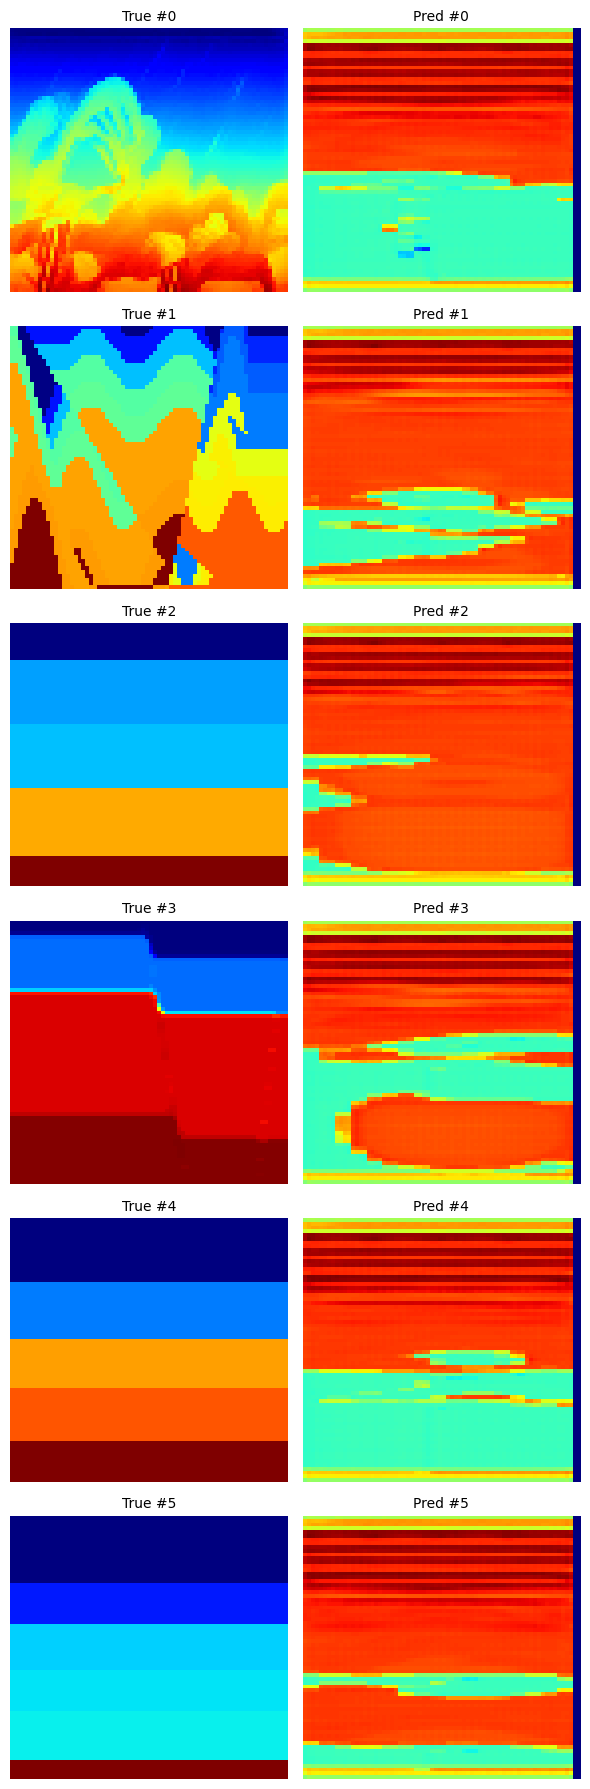

In [6]:
import matplotlib.pyplot as plt

# --- 1) モデルを評価モードにして、検証データの最初のバッチを取得 ---
model.eval()
with torch.no_grad():
    xb, yb = next(iter(val_loader))               # バッチ取得
    preds = model(xb.to(device)).cpu().numpy()    # 予測結果 (B,1,70,70)
    truths = yb.numpy()                           # 真の値 (B,1,70,70)

# --- 2) 描画するサンプル数 ---
n_show = 6   # 例: 最初の6サンプルを表示
cols   = 2   # 真 vs 予測
rows   = n_show

fig, axes = plt.subplots(rows, cols, figsize=(6, 3*rows))
for i in range(n_show):
    ax_true = axes[i,0]
    ax_pred = axes[i,1]
    # 真の速度マップ
    ax_true.imshow(truths[i,0], cmap='jet', aspect='auto')
    ax_true.set_title(f"True #{i}", fontsize=10)
    ax_true.axis('off')
    # 予測速度マップ
    ax_pred.imshow(preds[i,0], cmap='jet', aspect='auto')
    ax_pred.set_title(f"Pred #{i}", fontsize=10)
    ax_pred.axis('off')

plt.tight_layout()
plt.show()


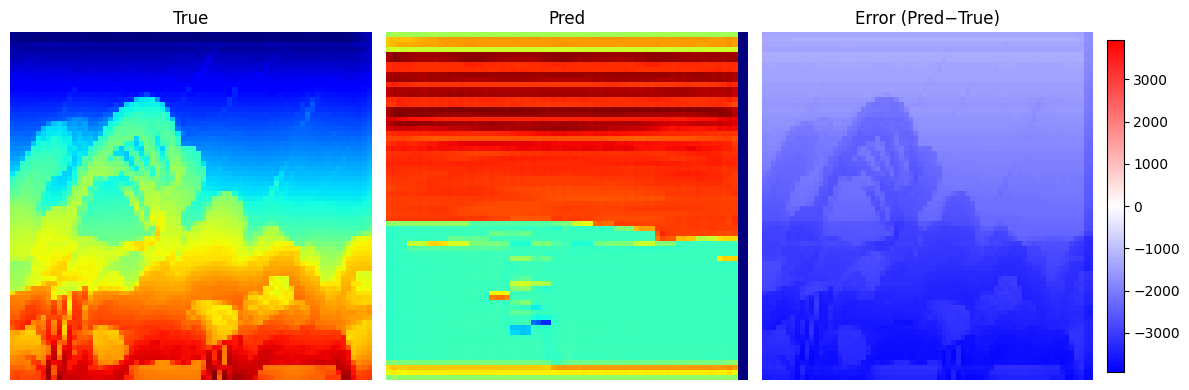

In [7]:
import matplotlib.pyplot as plt

# ① 検証データから一つサンプルを取得
model.eval()
with torch.no_grad():
    xb, yb = next(iter(val_loader))
    pred = model(xb.to(device)).cpu().numpy()[0,0]  # 1 枚取り出し
    true = yb.numpy()[0,0]

# ② 誤差マップを計算
error = pred - true

# ③ 真値・予測・誤差 を並べて表示
fig, axes = plt.subplots(1, 3, figsize=(12,4))

axes[0].imshow(true, cmap='jet', aspect='auto')
axes[0].set_title("True")
axes[0].axis('off')

axes[1].imshow(pred, cmap='jet', aspect='auto')
axes[1].set_title("Pred")
axes[1].axis('off')

im = axes[2].imshow(error, cmap='bwr', aspect='auto', vmin=-np.max(np.abs(error)), vmax=np.max(np.abs(error)))
axes[2].set_title("Error (Pred−True)")
axes[2].axis('off')
fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
